# RNNs Tutorial with PyTorch on the IMDB Dataset

In this tutorial, we will build a Recurrent Neural Network (CNN) to classify movie reviews as positive or negative using the IMDB dataset.
 
We'll go through the following steps:

1. **Data Loading, Processing, and Augmentation**
2. **Data Exploration**
3. **Model Building**
4. **Model Training**
5. **Model Evaluation**



## 1. Data Loading, Processing, and Augmentation

The IMDB dataset contains 50,000 movie reviews, split into 25,000 reviews for training and 25,000 reviews for testing. The dataset is preprocessed, and each review is encoded as a sequence of word indexes.

### Exercise 1.1 - Data Loading and Processing

1. Load the data from `'../../data/imdb_dataset.zip'` using pandas.
2. Convert the `sentiment` column to a binary label (0 for negative and 1 for positive).
3. Split the dataset into training and test sets (25,000 samples each).
4. Preprocess the `review` column by converting it to lowercase and removing special characters, punctuation and stopwords. Additionally, use a stemming or lemmatization technique.
5. Build a vocabulary of unique words in the training dataset.
6. Tokenize the reviews using the vocabulary, i.e., replace each word with its index in the vocabulary. Note that the reviews should be padded to a fixed length.
7. Create the data loaders for training and test datasets.


In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv('../../data/imdb_dataset.zip', compression='zip')  # Load as per your format
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [3]:
# Split the dataset
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.5, random_state=42)
train_df.shape, test_df.shape

((25000, 2), (25000, 2))

In [4]:
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

nltk.download('punkt')

stemmer = nltk.PorterStemmer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, including numbers
    text = re.sub(r'\W', ' ', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    # stemming
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

train_df['preproc_review'] = train_df['review'].apply(preprocess_text)
test_df['preproc_review'] = test_df['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /home/joao-
[nltk_data]     correia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/joao-
[nltk_data]     correia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# build vocabulary
def tokenize_text(text):
    return nltk.word_tokenize(text)

train_df['tokens'] = train_df['preproc_review'].apply(tokenize_text)
test_df['tokens'] = test_df['preproc_review'].apply(tokenize_text)

all_tokens = set([word for tokens in train_df['tokens'] for word in tokens])
# get top 5000 words
top_5000 = pd.Series([word for tokens in train_df['tokens'] for word in tokens]).value_counts().index[:5000]
vocab = {word: i + 2 for i, word in enumerate(top_5000)}
vocab['<unk>'] = 0
vocab['<pad>'] = 1

len(vocab)

5002

In [6]:
# Tokenize reviews
def tokenize_review(tokens):
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

train_df['tokenized'] = train_df['tokens'].apply(tokenize_review)
test_df['tokenized'] = test_df['tokens'].apply(tokenize_review)

In [7]:
train_df.head()

,review,sentiment,preproc_review,tokens,tokenized
25858,"""Congo"" is based on the best-selling novel by ...",0,congo base best sell novel michael crichton th...,"[congo, base, best, sell, novel, michael, cric...","[0, 323, 52, 1133, 507, 423, 0, 95, 302, 0, 28..."
10784,"Wow, here it finally is; the action ""movie"" wi...",0,wow final action movi without action real low ...,"[wow, final, action, movi, without, action, re...","[1132, 141, 110, 3, 131, 110, 72, 295, 256, 87..."
24807,'Identity . . . . I am part of my surrounding...,1,ident part surround becam separ abl make diffe...,"[ident, part, surround, becam, separ, abl, mak...","[1366, 67, 1235, 857, 1630, 432, 8, 0, 664, 16..."
49534,"""Sir"" John Gielgud must have become senile to ...",0,sir john gielgud must becom senil star mess mo...,"[sir, john, gielgud, must, becom, senil, star,...","[2150, 253, 0, 129, 142, 0, 82, 730, 3, 6, 5, ..."
3345,Below average movie with poor music considerin...,0,averag movi poor music consid movi base music ...,"[averag, movi, poor, music, consid, movi, base...","[795, 3, 271, 81, 358, 3, 323, 81, 1662, 124, ..."


In [8]:
from torch.utils.data import TensorDataset, DataLoader

MAX_LENGTH = 300

def pad_or_truncate(indices, max_length=MAX_LENGTH):
    if len(indices) > max_length:
        return indices[:max_length]  # Truncate if longer than max_length
    else:
        return indices + [1] * (max_length - len(indices))  # Pad if shorter

train_df['padded_tokenized'] = train_df['tokenized'].apply(lambda x: pad_or_truncate(x, MAX_LENGTH))
test_df['padded_tokenized'] = test_df['tokenized'].apply(lambda x: pad_or_truncate(x, MAX_LENGTH))

In [9]:
# Convert the data to tensors
def prepare_data(df):
    inputs = torch.tensor(df['padded_tokenized'].tolist())
    labels = torch.tensor(df['sentiment'].tolist())
    return TensorDataset(inputs, labels)

train_data = prepare_data(train_df)
test_data = prepare_data(test_df)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

### Exercise 1.2 - Data Augmentation

1. Define a function to replace random words with synonyms from WordNet in the reviews.
2. Augment the training dataset by replacing words in a few reviews with synonyms.

Note: Never augment the test dataset. It's essential to evaluate the model on the original data.

In [10]:
import random
from nltk.corpus import wordnet

nltk.download('wordnet')

def augment_text(text, max_augment=3):
    tokens = text.split()[:20]
    augmented_tokens = tokens.copy()
    
    for _ in range(max_augment):
        if len(augmented_tokens) > 1:
            rand_idx = random.randint(0, len(augmented_tokens) - 1)
            word = augmented_tokens[rand_idx]
            synonyms = wordnet.synsets(word)
            if synonyms:
                replacement = random.choice(synonyms).lemmas()[0].name()
                augmented_tokens[rand_idx] = replacement
    print(f"Original: {' '.join(tokens)}")
    print(f"Augmented: {' '.join(augmented_tokens)}")
    print('\n\n')
    return ' '.join(augmented_tokens)

# Apply augmentation to training set
train_df['review'].iloc[:3].apply(lambda x: augment_text(x, max_augment=3))

[nltk_data] Downloading package wordnet to /home/joao-
[nltk_data]     correia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original: "Congo" is based on the best-selling novel by Michael Crichton, which I thought lacked Crichton's usual charm, smart characters and
Augmented: "Congo" is based on the best-selling novel by Michael Crichton, which one thought miss Crichton's usual charm, smart characters and



Original: Wow, here it finally is; the action "movie" without action. In a real low-budget setting (don't miss the hilarious flying
Augmented: Wow, here it finally is; the action "movie" without action. inch a real low-budget setting (don't miss the hilarious flying



Original: 'Identity . . . . I am part of my surroundings and I became separate from them and it's being
Augmented: 'Identity . . . . I am part of my surroundings and I became separate from them and it's being


25858    "Congo" is based on the best-selling novel by ...
10784    Wow, here it finally is; the action "movie" wi...
24807    'Identity . . . . I am part of my surrounding...
Name: review, dtype: object

## 2. Data Exploration

Before training our model, it's essential to explore the data. This helps us understand its distribution and visualize some examples.

### Exercise 2 - Data Exploration
1. Print the number of positive and negative reviews in the training and test datasets.
2. Plot a histogram of the length of reviews in the training and test datasets.
3. Print a few reviews and their corresponding sentiment labels.

In [11]:
# number of positive and negative reviews
train_df['sentiment'].value_counts(), test_df['sentiment'].value_counts()

(sentiment
 0    12517
 1    12483
 Name: count, dtype: int64,
 sentiment
 1    12517
 0    12483
 Name: count, dtype: int64)

(array([3.0260e+03, 1.0931e+04, 4.7480e+03, 2.4410e+03, 1.3860e+03,
        9.0700e+02, 5.3200e+02, 3.6400e+02, 2.6400e+02, 1.7100e+02,
        1.2300e+02, 6.9000e+01, 1.7000e+01, 6.0000e+00, 3.0000e+00,
        3.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   4.        ,   52.36666667,  100.73333333,  149.1       ,
         197.46666667,  245.83333333,  294.2       ,  342.56666667,
         390.93333333,  439.3       ,  487.66666667,  536.03333333,
         584.4       ,  632.76666667,  681.13333333,  729.5       ,
         777.86666667,  826.23333333,  874.6       ,  922.96666667,
         971.33333333, 1019.7       , 1068.06666667, 1116.43333333,
        1164.8       , 1213.16666667, 1261.53333333, 1309.9       ,
        1358.26666667, 1406.63333333, 1455.        ]),
 <BarContainer object of 30 artists>)

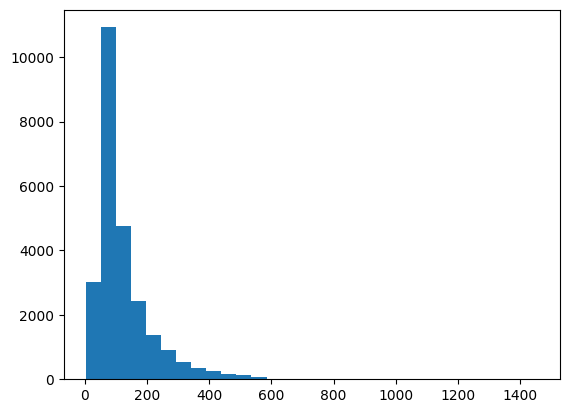

In [12]:
# length of reviews (histogram)
import matplotlib.pyplot as plt

sizes = train_df['tokenized'].apply(len)
plt.hist(sizes, bins=30)

(array([2.124e+03, 8.784e+03, 5.773e+03, 2.861e+03, 1.838e+03, 1.132e+03,
        7.550e+02, 5.450e+02, 3.500e+02, 2.590e+02, 1.810e+02, 1.680e+02,
        1.160e+02, 6.900e+01, 3.300e+01, 7.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([   3. ,   43.4,   83.8,  124.2,  164.6,  205. ,  245.4,  285.8,
         326.2,  366.6,  407. ,  447.4,  487.8,  528.2,  568.6,  609. ,
         649.4,  689.8,  730.2,  770.6,  811. ,  851.4,  891.8,  932.2,
         972.6, 1013. , 1053.4, 1093.8, 1134.2, 1174.6, 1215. ]),
 <BarContainer object of 30 artists>)

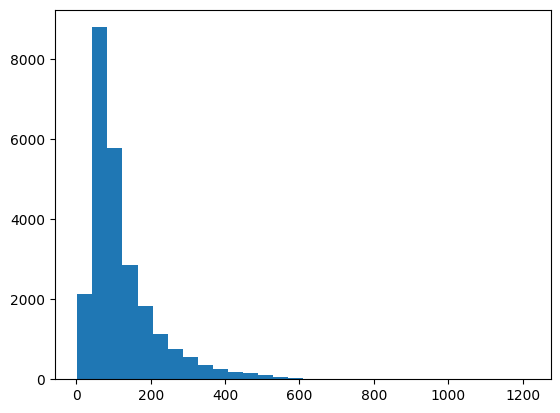

In [13]:
sizes = test_df['tokenized'].apply(len)
plt.hist(sizes, bins=30)

In [14]:
# print reviews and sentiment labels
for i in range(5):
    print(f"Review: {train_df['review'].iloc[i]}\nSentiment: {train_df['sentiment'].iloc[i]}\n")

Review: "Congo" is based on the best-selling novel by Michael Crichton, which I thought lacked Crichton's usual charm, smart characters and punch. Well, sorry to say, but the same goes for the film.<br /><br />Here's the plot:<br /><br />Greed is bad, this simple morality tale cautions. A megalomaniacal C.E.O. (Joe Don Baker) sends his son into the dangerous African Congo on a quest for a source of diamonds large enough and pure enough to function as powerful laser communications transmitter (or is it laser weapons?). When contact is lost with his son and the team, his daughter-in-law (Laura Linney), a former CIA operative and computer-freak, is sent after them. On her quest, she is accompanied by gee-whiz gadgetry and a few eccentric characters (including a mercenary (Ernie Hudson), a researcher with a talking gorilla (Dylan Walsh), and a a nutty Indiana-Jones-type looking for King Solomon's Mines (Tim Curry). After some narrow escapes from surface-to-air missiles and some African wil

## 3. Model Building

Now, we'll define our RNN architecture. A typical RNN consists of an embedding layer, RNN layers, and a fully connected layers.

### Exercise
1. Define a RNN class inheriting from torch.nn.Module.
2. Include one Embedding layer, two LSTM layers, and two Linear layers.

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.rnn2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, int(hidden_size/2))
        self.fc2 = nn.Linear(int(hidden_size/2), output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x) # output, (h_n, c_n). h_n is the hidden state of the layer, c_n is the cell state of the layer
        x, (hn, cn) = self.rnn2(x)
        x = F.relu(self.fc(hn[-1]))
        x = self.fc2(x)
        return self.sigmoid(x)

# Model initialization
model = RNNModel(vocab_size=len(vocab), embed_size=128, hidden_size=64, output_size=1)
model

RNNModel(
  (embedding): Embedding(5002, 128)
  (rnn): LSTM(128, 64, batch_first=True)
  (rnn2): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## 4. Model Training

We'll now define the training loop to optimize our model using the binary cross-entropy loss function and the Adam optimizer.

### Exercise
1. Define a function to train the model for a specified number of epochs.
2. Print the training loss after each epoch.

In [16]:
import torch
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

# Hyperparameters
epochs = 5
learning_rate = 0.001

# Loss and optimizer
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = loss_fn(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = (outputs.squeeze() > 0.5).long()
        correct_preds += (predictions == labels).sum().item()
        total_preds += len(labels)

    accuracy = correct_preds / total_preds
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy*100:.2f}%")

RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [86]:
print(texts)

tensor([[43593, 58655, 67253,  ..., 74555, 35961, 57393],
        [ 2166,  8269, 19154,  ...,     1,     1,     1],
        [17991, 52254, 59359,  ...,     1,     1,     1],
        ...,
        [46424, 24314, 73279,  ...,     1,     1,     1],
        [36647, 42199,  1048,  ...,     1,     1,     1],
        [10860, 11215, 25506,  ...,     1,     1,     1]], device='cuda:0')


## 5. Model Evaluation

After training, we need to evaluate our model on the test dataset to understand its performance.

### Exercise
1. Define a function to evaluate the model's accuracy on the test set.
2. Print the accuracy.

In [81]:
# Evaluation loop
model.eval()
correct_preds = 0
total_preds = 0
with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        predictions = (outputs.squeeze() > 0).long()
        correct_preds += (predictions == labels).sum().item()
        total_preds += len(labels)

accuracy = correct_preds / total_preds
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 50.07%
